# Network-based Gene Prioritization from GWAS Data
MED283: Network Biology & Biomedicine  
Nadia Arang & Kevin Chau

In [1]:
%matplotlib inline

import ndex2
import math
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Initial data loading

GIANT
> Greene CS*, Krishnan A*, Wong AK*, Ricciotti E, Zelaya RA, Himmelstein DS, Zhang R, Hartmann BM, Zaslavsky E, Sealfon SC, Chasman DI, FitzGerald GA, Dolinski K, Grosser T, Troyanskaya OG. (2015). Understanding multicellular function and disease with human tissue-specific networks. Nature Genetics. 10.1038/ng.3259w.

PCNet
> Huang JK*, Carlin DE*, Yu MK, Zhang W, Kreisberg JF, Tamayo P, Ideker T. (2018). Systematic Evaluation of Molecular Networks for Discovery of Disease Genes. Cell Systems. 4 (6): 484-495.e5. doi: 10.1016/j.cels.2018.03.001

In [2]:
# Load network from server
# PCNet
# pc_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
#                                            uuid = "f93f402c-86d4-11e7-a10d-0ac135e8bacf")

# GIANT; Brain-specific, 0.2-confidence filter
bn_nice = ndex2.create_nice_cx_from_server(server = "http://public.ndexbio.org", 
                                           uuid = "19677bff-6037-11e8-a4bf-0ac135e8bacf")

In [3]:
# Cast as networkx object
# First cast to pandas since networkx 2.1 is incompatible with ndex2
# nt_pd = pc_nice.to_pandas_dataframe()
nt_pd = bn_nice.to_pandas_dataframe()
net = nx.from_pandas_edgelist(nt_pd)

In [4]:
# Load gene summary table
gene_summaries_given = pd.read_csv("../src/gene_level_summary_stats_pmid_25056061.txt", 
                                   header = 0, sep = '\t', index_col = 1)
gene_summaries_given.head()

,Unnamed: 0,Chr,Gene Start,Gene End,nSNPs,TopSNP,TopSNP Pos,TopSNP P-Value,SNP Distance
Gene,,,,,,,,,
HIST1H4K,5905,6,27906930,27907284,8,rs34706883,27913234.0,5.071180e-10,6304.0
HIST1H2AK,5867,6,27913636,27914096,16,rs34706883,27913234.0,5.071180e-10,402.0
HIST1H2BN,5883,6,27914418,27914867,17,rs34706883,27913234.0,5.071180e-10,1184.0
HIST1H2AL,5868,6,27941085,27941555,10,rs13199772,27942064.0,7.053790e-10,979.0
HIST1H1B,5855,6,27942548,27943338,10,rs13199772,27942064.0,7.053790e-10,484.0


Text(0.5,0,'Chromosome')

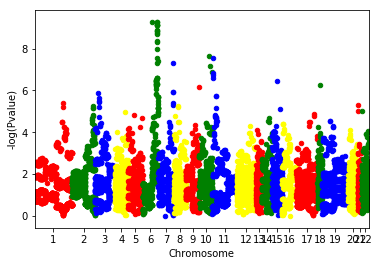

In [5]:
# Quick Manhattan plot
gs_man = gene_summaries_given
gs_man["-log(Pvalue)"] = -np.log10(gene_summaries_given["TopSNP P-Value"])
gs_man["Chr"] = gene_summaries_given["Chr"].astype("category")
gs_man = gene_summaries_given.sort_values("Chr")

gs_man["ind"] = range(len(gs_man))
gs_groups = gs_man.groupby(("Chr"))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ["red", "green", "blue", "yellow"]

x_labels = []
x_labels_pos = []

for num, (name, group) in enumerate(gs_groups):
    group.plot(kind = "scatter", x = "ind", y = "-log(Pvalue)", color = colors[num % len(colors)], ax = ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(gs_man)])
# ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')

In [6]:
# Load snp summary table
snp_summaries = pd.read_csv("../src/snp_level_summary_stats_pmid_25056061.txt", 
                            header = 0, sep = '\t', index_col = 0, na_values = ".")
snp_summaries.head()

,hg18chr,bp,a1,a2,or,se,pval,info,ngt,CEUaf
snpid,,,,,,,,,,
rs3131972,1,742584,A,G,1.0257,0.0835,0.761033,0.1613,0,0.160550
rs3131969,1,744045,A,G,1.0221,0.0801,0.784919,0.2225,0,0.133028
rs3131967,1,744197,T,C,1.0227,0.0858,0.793520,0.2060,0,NaN
rs1048488,1,750775,T,C,0.9749,0.0835,0.761041,0.1613,0,0.836449
rs12562034,1,758311,A,G,1.0011,0.0756,0.987899,0.1856,3,0.092593


### Gene significance by normalized p-value

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3128073/

Text(0.5,1,'Initial Gene P-values')

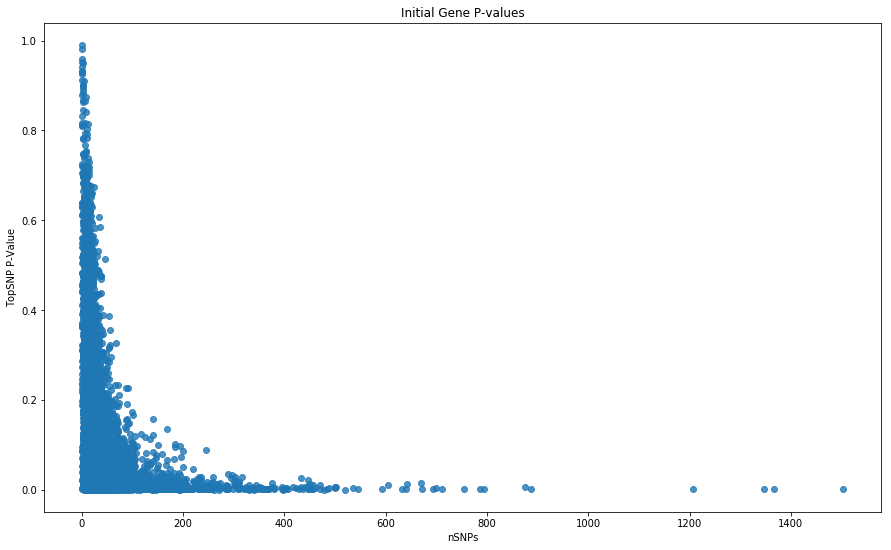

In [96]:
# Rationale
fig2 = plt.figure(figsize = (15, 9))
ax = fig2.add_subplot(111)
sns.regplot((gene_summaries_given["nSNPs"]), (gene_summaries_given["TopSNP P-Value"]), fit_reg = False)
ax.set_title("Initial Gene P-values")

In [97]:
fig2.savefig("../data/gene_snp_correlation.png")

In [9]:
from scipy.stats import pearsonr
pearsonr(gene_summaries_given["nSNPs"], gene_summaries_given["TopSNP P-Value"])

(-0.20155646638624297, 5.578098517955562e-137)

There is clear correlation between number of captured SNPs and the assigned TopSNP p-value, so we should probably normalize gene score by number of captured SNPs

In [10]:
# Assign SNPs to genes based on +/- nkb window
nkb = 10

# Init new gene_summaries dataframe
gene_summaries = gene_summaries_given.loc[:, ["Chr", "Gene Start", "Gene End"]]
gene_summaries.head()

,Chr,Gene Start,Gene End
Gene,,,
HIST1H4K,6,27906930,27907284
HIST1H2AK,6,27913636,27914096
HIST1H2BN,6,27914418,27914867
HIST1H2AL,6,27941085,27941555
HIST1H1B,6,27942548,27943338


Rescoring genes normalized by number of SNPs actually assigned to the gene.

In [53]:
gene_scores = []
snp_counts = []
min_p = []
for gidx, gene in gene_summaries.iterrows():
    chrom = gene["Chr"]
    
    # filter for chromosome
    this_snps = snp_summaries[snp_summaries["hg18chr"] == chrom]
    
    # filter for upstream endpoint
    this_snps = this_snps[this_snps["bp"] >= gene["Gene Start"] - (nkb * 1000)]
    
    # filter for downstream endpoint
    this_snps = this_snps[this_snps["bp"] <= gene["Gene End"] + (nkb * 1000)]
    
    # Calculate adjusted bonferroni-adjusted p-value -> "gene score"
    # pvals = [p * snp_summaries.shape[0] for p in this_snps.loc[:, "pval"].tolist()]
    pvals = [p for p in this_snps.loc[:, "pval"].tolist()]
    adj_score = min(pvals) * len(pvals)
    min_p.append(min(pvals))
    gene_scores.append(adj_score)
    snp_counts.append(len(pvals))
gene_summaries["Gene Score"] = gene_scores
gene_summaries["nSNPs"] = snp_counts
gene_summaries["TopSNP P-Value"] = min_p

In [54]:
gene_summaries_preoverlap = gene_summaries
gene_summaries_preoverlap.head()

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScorePR,Gene ReScoreRWR,-log(Gene Score),-log(Gene ReScoreRWR),-log(Gene ReScorePR)
Gene,,,,,,,,,,,
HIST1H4K,6,27906930,27907284,4.056944e-09,8,5.071180e-10,6.338975e-11,6.338975e-11,10.197981,10.197981,10.197981
HIST1H2AK,6,27913636,27914096,8.113888e-09,16,5.071180e-10,3.169488e-11,3.169488e-11,10.499011,10.499011,10.499011
HIST1H2BN,6,27914418,27914867,8.621006e-09,17,5.071180e-10,4.830025e-18,6.986509e-03,10.525340,2.155740,17.316051
HIST1H2AL,6,27941085,27941555,7.053790e-09,10,7.053790e-10,7.053790e-11,7.053790e-11,10.151577,10.151577,10.151577
HIST1H1B,6,27942548,27943338,7.053790e-09,10,7.053790e-10,7.910794e-15,7.258011e-03,10.151577,2.139182,14.101780


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Gene Score Distribution')

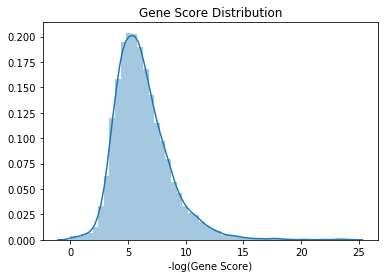

In [16]:
fig_dist = plt.figure()
ax = fig_dist.add_subplot(111)
sns.distplot(-np.log(gene_summaries["Gene Score"]))
ax.set_xlabel("-log(Gene Score)")
ax.set_title("Gene Score Distribution")

In [17]:
fig_dist.savefig("../data/GeneScoreDistribution.png")

In [18]:
new_threshold = (0.05 / 20000)
new_threshold

2.5e-06

Initial size of significant gene set

In [59]:
gene_summaries[gene_summaries["Gene Score"] <= new_threshold].shape

(22, 11)

### Adding information to the network

In [20]:
nx.set_node_attributes(net, values = gene_summaries.T.to_dict())

## PageRank

Create normalized adjacency matrix

In [55]:
person = {idx: _["Gene Score"] for idx, _ in gene_summaries.iterrows()}

In [56]:
pagerank = nx.pagerank(net, personalization = person)
gene_summaries["Gene ReScorePR"] = [pagerank[_] * gene_summaries.loc[_, "Gene Score"] 
                                    if _ in pagerank else gene_summaries.loc[_, "Gene Score"]
                                    for _ in gene_summaries.index]

In [90]:
gene_summaries[gene_summaries["Gene ReScorePR"] <= new_threshold]

,Chr,Gene Start,Gene End,Gene Score,nSNPs,TopSNP P-Value,Gene ReScorePR,Gene ReScoreRWR,-log(Gene Score),-log(Gene ReScoreRWR),-log(Gene ReScorePR)
Gene,,,,,,,,,,,
HIST1H4K,6,27906930,27907284,4.056944e-09,8,5.071180e-10,4.056944e-09,6.338975e-11,8.391801,10.197981,8.391801
HIST1H2AK,6,27913636,27914096,8.113888e-09,16,5.071180e-10,8.113888e-09,3.169488e-11,8.090771,10.499011,8.090771
HIST1H2BN,6,27914418,27914867,8.621006e-09,17,5.071180e-10,1.458450e-15,6.986509e-03,8.064442,2.155740,14.836108
HIST1H2AL,6,27941085,27941555,7.053790e-09,10,7.053790e-10,7.053790e-09,7.053790e-11,8.151577,10.151577,8.151577
HIST1H1B,6,27942548,27943338,7.053790e-09,10,7.053790e-10,8.177586e-13,7.258011e-03,8.151577,2.139182,12.087375
HIST1H3I,6,27947601,27948078,7.053790e-09,10,7.053790e-10,7.053790e-09,7.053790e-11,8.151577,10.151577,8.151577
HIST1H4L,6,27948904,27949268,7.053790e-09,10,7.053790e-10,7.053790e-09,7.053790e-11,8.151577,10.151577,8.151577
PGBD1,6,28357342,28378305,3.708120e-08,30,1.236040e-09,4.643083e-14,7.012471e-03,7.430846,2.154129,13.333194
HIST1H1E,6,26264537,26265322,1.603910e-08,11,1.458100e-09,1.323071e-13,6.836319e-03,7.794820,2.165178,12.878417


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


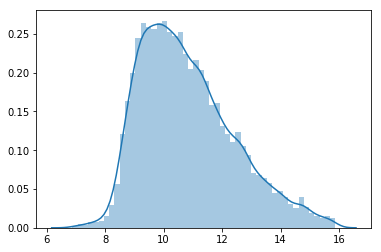

In [26]:
sns.distplot(-np.log(list(pagerank.values())))

## Validation

In [65]:
def jaccard(a, b): 
    return(len(set(a) & set(b)) / len(set(a) | set(b)))

In [77]:
szdb = pd.read_csv("../src/szdb.csv")
szdb_list = szdb["Symbol"].tolist()

In [84]:
pr_list = gene_summaries.sort_values(by = "Gene ReScorePR", axis = 0).index.tolist()

In [88]:
jaccard(szdb_list, pr_list[:len(szdb_list)])

0.08848614072494669

There is an approximate 8.8% overlap between our found top genes and the genes in SZDB.

## Output

In [93]:
gene_summaries.to_csv("../data/scoredGenes.csv")

Text(0.5,1,'Pre-Network Propagation Scores')

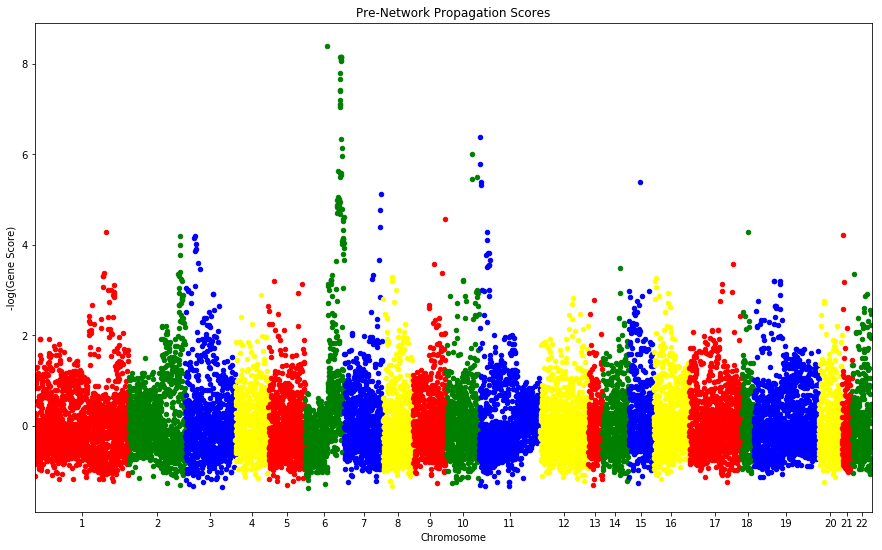

In [60]:
gs_man = gene_summaries
gs_man["-log(Gene Score)"] = -np.log10(gs_man["Gene Score"])
gs_man["Chr"] = gene_summaries["Chr"].astype("category")
gs_man = gene_summaries.sort_values("Chr")

gs_man["ind"] = range(len(gs_man))
gs_groups = gs_man.groupby(("Chr"))

fig_man_1 = plt.figure(figsize = (15, 9))
ax = fig_man_1.add_subplot(111)
colors = ["red", "green", "blue", "yellow"]

x_labels = []
x_labels_pos = []

for num, (name, group) in enumerate(gs_groups):
    group.plot(kind = "scatter", x = "ind", y = "-log(Gene Score)", color = colors[num % len(colors)], ax = ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(gs_man)])
# ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')
ax.set_title("Pre-Network Propagation Scores")

In [61]:
fig_man_1.savefig("../data/initScoreManhattan.png")

Text(0.5,1,'Post-Network Propagation Scores')

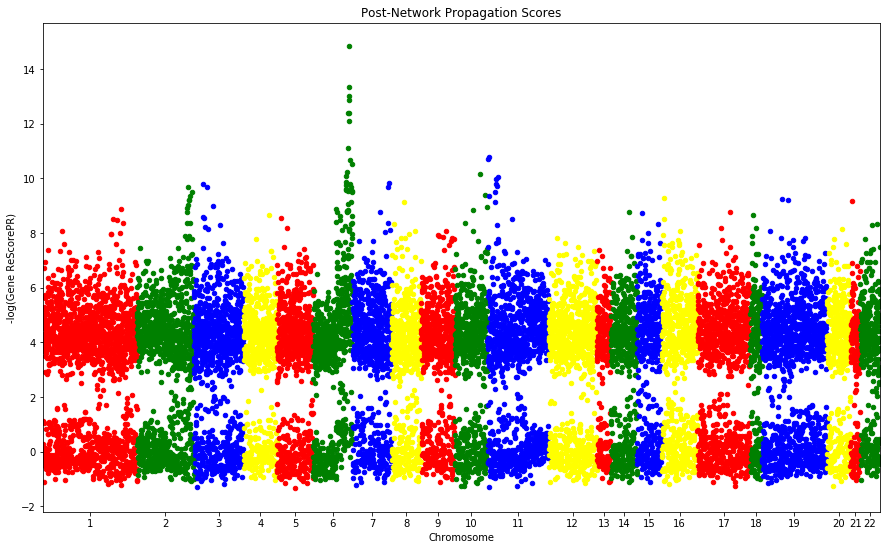

In [62]:
# Quick Manhattan plot
gs_man = gene_summaries
gs_man["-log(Gene ReScorePR)"] = -np.log10(gs_man["Gene ReScorePR"])
gs_man["Chr"] = gene_summaries["Chr"].astype("category")
gs_man = gene_summaries.sort_values("Chr")

gs_man["ind"] = range(len(gs_man))
gs_groups = gs_man.groupby(("Chr"))

fig_man_1 = plt.figure(figsize = (15, 9))
ax = fig_man_1.add_subplot(111)
colors = ["red", "green", "blue", "yellow"]

x_labels = []
x_labels_pos = []

for num, (name, group) in enumerate(gs_groups):
    group.plot(kind = "scatter", x = "ind", y = "-log(Gene ReScorePR)", color = colors[num % len(colors)], ax = ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
    
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(gs_man)])
# ax.set_ylim([0, 3.5])
ax.set_xlabel('Chromosome')
ax.set_title("Post-Network Propagation Scores")

In [63]:
fig_man_1.savefig("../data/PostPRScoreManhattan.png")